## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import cv2
import time
import pickle 
import shutil 
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from sys import getsizeof
import matplotlib.pyplot as plt

import faiss
import face_recognition
from deepface import DeepFace
from multiprocessing import Pool, cpu_count


## Initializing Constants

In [2]:
MODEL_NAME = "ArcFace" 
DETECTOR_BACKEND = "mtcnn" 
NORMALIZATION = "ArcFace"

TARGET_SIZE = (112, 112) 
NUM_OF_DIMS = 512 

# DB_SOURCE = Path("./DB/")  
# QUERY_SOURCE = Path("./QueryImages/") 
DESTINATION = Path("../data/CleanData/")

## Data Cleaning

In [24]:
# iterr = 0

# for person_img in os.listdir(DB_SOURCE):
#     person_name = os.path.splitext(person_img)[0]
#     dest_person_name = person_name.replace(" ", "_").replace(".", "").lower()
#     if len(os.listdir(QUERY_SOURCE / person_name)) == 5:
#         os.makedirs(str(DESTINATION / dest_person_name), exist_ok=True)
#         for index, image in enumerate(os.listdir(QUERY_SOURCE / person_name)):
#             img_source = str(QUERY_SOURCE / person_name / image)     
#             img_destination = str(DESTINATION / dest_person_name / f"{index}{os.path.splitext(image)[1]}")
#             shutil.copy(img_source, img_destination)
#             iterr += 1
#         img_source = str(DB_SOURCE / person_img)
#         img_destination = str(DESTINATION / dest_person_name / f"{index+1}{os.path.splitext(image)[1]}")
#         shutil.copy(img_source, img_destination)
#         iterr += 1

# iterr # 768

768

## Utility Functions

In [3]:
def read_img(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def face_extraction_and_alignment(img_path):
    return DeepFace.extract_faces(
        img_path = img_path,
        target_size = TARGET_SIZE,
        detector_backend = DETECTOR_BACKEND,
        enforce_detection = True,
        align = True,
        grayscale = False,
    )[0]["face"]

In [5]:
def compare_original_and_extracted_face(img_path):
    target_img = face_extraction_and_alignment(img_path)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    original_img = read_img(img_path) 
    ax[0].imshow(original_img) 
    ax[0].axis("off")
    ax[1].imshow(target_img)
    ax[1].axis("off")
    plt.show()

In [6]:
def show_pic(img_path):
    img = read_img(img_path) 
    plt.imshow(img) 
    plt.axis("off")
    plt.show()

In [7]:
def face_enc_with_fr(img_path, known_face_locations):
    image_arr = face_recognition.load_image_file(img_path)
    img_enc = face_recognition.face_encodings(
        model='large', 
        face_image=image_arr, 
        known_face_locations=[known_face_locations], 
        num_jitters=1, 
    )[0]
    return img_enc 

def face_enc_and_coordinates_with_df(img_path):
    representation = DeepFace.represent(
        img_path=img_path,
        model_name=MODEL_NAME,
        normalization=NORMALIZATION,
        detector_backend=DETECTOR_BACKEND,
        align=True,
        enforce_detection=True,
    )[0]
    face_coordinates = representation["facial_area"]
    face_enc = representation["embedding"]
    face_enc = np.array(face_enc, dtype="f")
    # Extracting the coordinates and dimensions
    left = face_coordinates['x']
    top = face_coordinates['y']
    right = left + face_coordinates['w']
    bottom = top + face_coordinates['h']
    return [face_enc, (top, right, bottom, left)]

## Visualizing the dataset

1/1 [==============================] - 0s 106ms/step


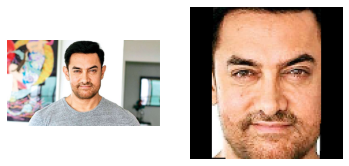

In [8]:
compare_original_and_extracted_face(str(DESTINATION / "aamir_khan" / "5.jpg"))

1/1 [==============================] - 0s 23ms/step

Face Detection and Alignment took time 1.1056411266326904 seconds



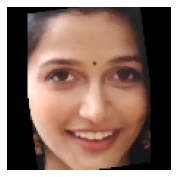

In [9]:
tic = time.time()
detected_and_aligned_face = face_extraction_and_alignment(str(DESTINATION / "anaika_soti" / "5.jpg")) 
toc = time.time() 
print(f"\nFace Detection and Alignment took time {toc-tic} seconds\n") 
plt.figure(figsize=(3, 3))
plt.imshow(detected_and_aligned_face)
plt.axis("off")
plt.show()

## Vectorizing the DataBase & Query Images

In [10]:
[enc, coordi] = face_enc_and_coordinates_with_df(
    str(DESTINATION / "anaika_soti" / "5.jpg")
    )

1/1 [==============================] - 0s 20ms/step


In [11]:
len(enc)

512

In [12]:
len(coordi)

4

In [13]:
DB_FACE_PATHS = []

for person_name in os.listdir(DESTINATION):
    for img_name in os.listdir(DESTINATION / person_name):
        img_path = str(DESTINATION / person_name / img_name)
        DB_FACE_PATHS.append(img_path)

with open(f'../artifacts/DB_FACE_PATHS.pickle', 'wb') as handle:
    pickle.dump(DB_FACE_PATHS, handle, protocol = pickle.HIGHEST_PROTOCOL) 

In [14]:
DB_FACE_ENC = []
DB_FACE_COORDINATES = []

for img_path in DB_FACE_PATHS:
    [encoding, coordinates] = face_enc_and_coordinates_with_df(img_path)
    DB_FACE_ENC.append(encoding)
    DB_FACE_COORDINATES.append(coordinates)

1/1 [==============================] - 0s 18ms/step


In [16]:
with open("../artifacts/DB_FACE_ENC.pickle", "wb") as handle:
    pickle.dump(DB_FACE_ENC, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open("../artifacts/DB_FACE_COORDINATES.pickle", "wb") as handle:
    pickle.dump(DB_FACE_COORDINATES, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [18]:
DB_FACE_PATHS[0]

'../data/CleanData/arun_vijay/5.jpg'

In [19]:
DB_FACE_ENC[0]

array([ 0.18435933,  0.49773747,  0.13786787, -0.2540668 , -0.12604477,
        0.03110872, -0.08152402, -0.09364262, -0.13283935,  0.0771507 ,
        0.01605895, -0.01110956,  0.22459602, -0.00637902, -0.28298488,
        0.08602037,  0.05095342, -0.16311826, -0.08634909, -0.08378378,
       -0.2683777 ,  0.29451802, -0.05708719,  0.06768057, -0.02299292,
       -0.12453203, -0.10901503,  0.05639792, -0.10257238, -0.33633178,
        0.17509067,  0.0245811 ,  0.36532754, -0.30795714, -0.10176633,
       -0.18266729, -0.43746686,  0.12988335, -0.30016068,  0.19105582,
       -0.00607039,  0.3015557 , -0.03563511,  0.04834756, -0.29789606,
        0.05553386, -0.10650585, -0.01521879, -0.15489563,  0.0216104 ,
        0.07724538, -0.26118493, -0.20315616, -0.11229146,  0.10913074,
       -0.3127757 ,  0.13980919,  0.1710798 ,  0.20981151,  0.10441897,
        0.46719602,  0.01728977, -0.03118143, -0.20628576, -0.07737481,
       -0.14890468, -0.0220078 ,  0.15858243,  0.14385056, -0.07

In [20]:
DB_FACE_COORDINATES[0]

(142, 493, 399, 293)

## Importing the Vectorized Images and DB dictionaries

In [23]:
with open('../artifacts/DB_FACE_PATHS.pickle', 'rb') as handle:
    DB_FACE_PATHS = pickle.load(handle)

with open('../artifacts/DB_FACE_ENC.pickle', 'rb') as handle:
    DB_FACE_ENC = pickle.load(handle)

with open('../artifacts/DB_FACE_COORDINATES.pickle', 'rb') as handle:
    DB_FACE_COORDINATES = pickle.load(handle)

In [24]:
getsizeof(DB_FACE_COORDINATES)

6200

## Creating FAISS Indexing Object

In [25]:
embeddings = np.array(DB_FACE_ENC, dtype='f')

In [26]:
import faiss
tic = time.time()

# index = faiss.IndexFlatL2(NUM_OF_DIMS) # euclidean
FAISS_INDEXING_OBJ = faiss.IndexFlatIP(NUM_OF_DIMS) # cosine
faiss.normalize_L2(embeddings)

toc = time.time()
print(f"faiss instance is initialized in {toc-tic} seconds")

faiss instance is initialized in 0.003153085708618164 seconds


In [27]:
# add 1M sized facial database into faiss
tic = time.time()

FAISS_INDEXING_OBJ.add(embeddings)

toc = time.time()
print(f"{len(embeddings)} vectors stored in faiss intance in {toc-tic} seconds")

768 vectors stored in faiss intance in 0.0011107921600341797 seconds


In [28]:
with open(f'../artifacts/FAISS_INDEXING_OBJ.pickle', 'wb') as handle:
    pickle.dump(FAISS_INDEXING_OBJ, handle, protocol = pickle.HIGHEST_PROTOCOL)

## Searching for similar pictures with the FAISS Object

In [31]:
with open('../artifacts/FAISS_INDEXING_OBJ.pickle', 'rb') as handle:
    FAISS_INDEXING_OBJ = pickle.load(handle)

with open('../artifacts/DB_FACE_PATHS.pickle', 'rb') as handle:
    DB_FACE_PATHS = pickle.load(handle)

In [32]:
# target_path = "../data/CleanData/kartik_aaryan/5.jpg" 
# target_path = "../data/CleanData/anupama_parameswaran/5.jpg" 
# target_path = "../data/CleanData/aamir_khan/5.jpg" 
target_path = "../data/CleanData/alizeh_shah/5.jpg"
target_embedding = DB_FACE_ENC[DB_FACE_PATHS.index(target_path)]
target_embedding = np.expand_dims(target_embedding, axis=0)

In [33]:
k = 10 
tic = time.time()

distances, neighbours = FAISS_INDEXING_OBJ.search(target_embedding, k)

toc = time.time()
print(f"search completed in {toc - tic} seconds")

search completed in 0.0008437633514404297 seconds


In [34]:
neighbours

array([[229, 231, 275, 154, 230, 601, 150,  17, 474,   8]])

In [35]:
distances

array([[3.77675  , 2.131304 , 2.1059387, 1.9613909, 1.9456787, 1.9003044,
        1.7961913, 1.7634436, 1.753406 , 1.7183714]], dtype=float32)

1th closest image in 768 database


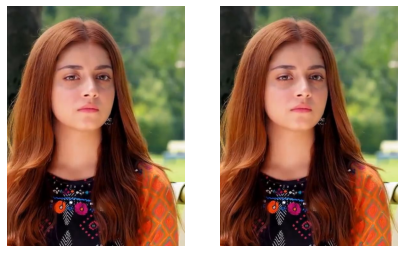

2th closest image in 768 database


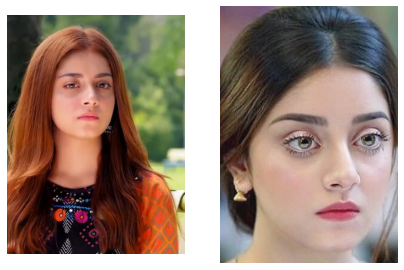

3th closest image in 768 database


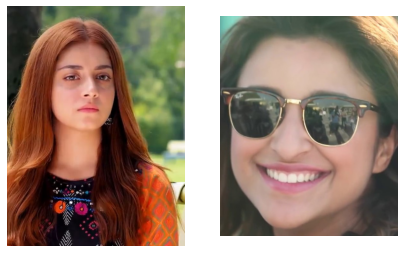

4th closest image in 768 database


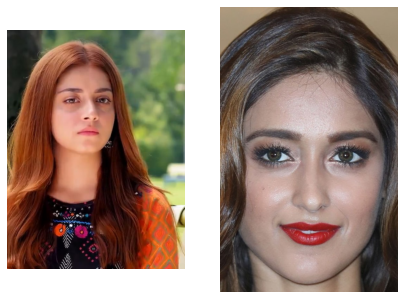

5th closest image in 768 database


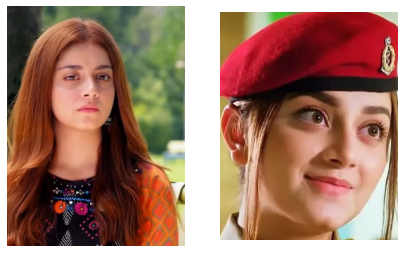

6th closest image in 768 database


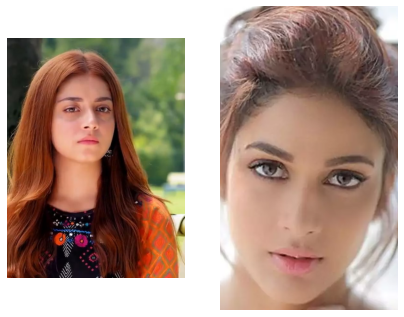

7th closest image in 768 database


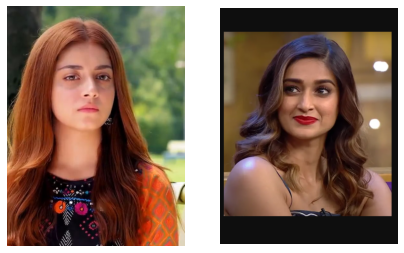

8th closest image in 768 database


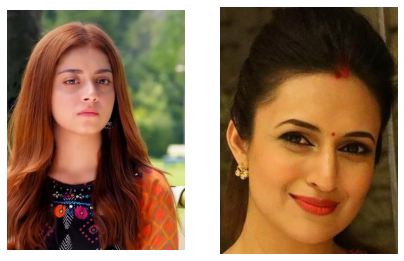

9th closest image in 768 database


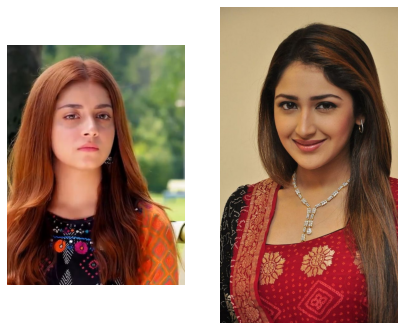

10th closest image in 768 database


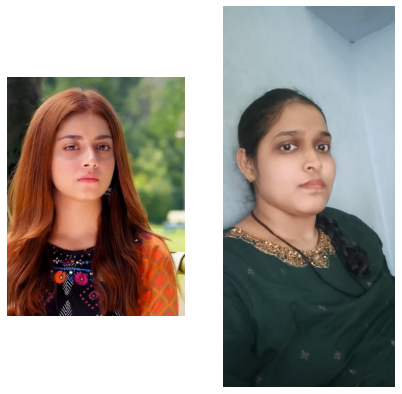

In [36]:
for idx, neighbour in enumerate(neighbours[0]):
    neighbour_img_path = DB_FACE_PATHS[neighbour]
    print(f"{idx+1}th closest image in {len(DB_FACE_PATHS)} database")
    fig = plt.figure(figsize=(7, 7))
    fig.add_subplot(1,2,1)
    plt.imshow(read_img(target_path))
    plt.axis("off")
    fig.add_subplot(1,2,2)
    plt.imshow(read_img(neighbour_img_path))
    plt.axis("off")
    plt.show()

## Exploring the face_recognition package

### Exploring compare_faces method

In [110]:
target_image_arr = face_recognition.load_image_file(target_path)

target_image_enc = face_recognition.face_encodings(
    face_image = target_image_arr,
    known_face_locations = None,
    num_jitters = 1,
    model = 'large',
)[0]

known_faces = []
for neighbour in neighbours[0]:
    neighbour_img_path = Query_face_path_reps_locations[neighbour][0]
    neighbour_img_arr = face_recognition.load_image_file(neighbour_img_path)
    neighbour_img_enc = face_recognition.face_encodings(
        face_image = neighbour_img_arr, 
        known_face_locations = None,
        num_jitters = 1,
        model = 'large',
    )[0]
    known_faces.append(neighbour_img_enc)

In [111]:
# results is an array of True/False telling if the unknown face matched anyone 
# in the known_faces array
results = face_recognition.compare_faces(
    known_faces, 
    target_image_enc,
    tolerance = 0.48
)
results

[True, False, False, True, False, False, False, False, False, False]

### Exploring face_distance method

In [112]:
distances = face_recognition.face_distance(
    face_encodings = known_faces, 
    face_to_compare = target_image_enc
)

In [113]:
distances 

array([0.        , 0.53957299, 0.6454748 , 0.46001816, 0.57873268,
       0.48891054, 0.73163636, 0.68846027, 0.7625775 , 0.65881117])

In [114]:
dic = dict(zip(neighbours[0], distances)) 

In [115]:
[(Query_face_path_reps_locations[item[0]][0], item[1]) for item in list(sorted(dic.items(), key=lambda item: item[1]))]

[('QueryImages/Aamir Khan/2.jpg', 0.0),
 ('QueryImages/Aamir Khan/4.png', 0.4600181572727369),
 ('QueryImages/Aamir Khan/1.jpg', 0.48891053873439455),
 ('QueryImages/Aamir Khan/5.png', 0.5395729860536199),
 ('QueryImages/Arya Cethirakath/3.png', 0.5787326779197571),
 ('QueryImages/Arya Cethirakath/1.jpg', 0.6454748027523287),
 ('QueryImages/bhanu/1.jpeg', 0.6588111662309186),
 ('QueryImages/Ali Fazal/1.jpg', 0.6884602680317772),
 ('QueryImages/Karthi/3.jpeg', 0.7316363606203832),
 ('QueryImages/Deepika Padukone/4.png', 0.762577503144426)]

### Exploring the Tolerance Value for compare_faces method

In [ ]:
tolerance = []
for person_1_img in tqdm(os.listdir(DB_SOURCE)):
    person_1_name = ".".join(person_1_img.split(".")[:-1])
    person_1_path = str(DB_SOURCE / person_1_img)
    # print(person_1_path)
    person_1_image_arr = face_recognition.load_image_file(person_1_path)
    person_1_image_enc = face_encodings(person_1_image_arr)
    known_faces = []
    for person_2_img in os.listdir(QUERY_SOURCE / person_1_name):
        person_2_path = str(QUERY_SOURCE / person_1_name / person_2_img)
        person_2_image_arr = face_recognition.load_image_file(person_2_path)
        person_2_image_enc = face_encodings(person_2_image_arr)
        known_faces.append(person_2_image_enc)
        # print(person_2_path)
    tances = face_recognition.face_tance(
        face_encodings = known_faces, 
        face_to_compare = person_1_image_enc
    )
    # print(tances)
    tolerance.append(np.median(tances))
    # print()
tolerance

100%|█████████████████████████████████████████| 129/129 [04:37<00:00,  2.15s/it]


[0.3556061539451734,
 0.43882977533940576,
 0.4577856250826683,
 0.5162375678348011,
 0.34650711539556717,
 0.4016819332194532,
 0.36440630517314204,
 0.414546116829475,
 0.3563400127245326,
 0.4313323466194446,
 0.4376168822727267,
 0.415872367702583,
 0.40315841191879903,
 0.4567871264339888,
 0.36115274379148854,
 0.3730248068897229,
 0.5009756837900061,
 0.41387466999567946,
 0.5128755700088553,
 0.37832125147783,
 0.35496560852691994,
 0.5318060770075619,
 0.4199226493791836,
 0.44550024853633435,
 0.48503693026441014,
 0.3681530358288588,
 0.38041923958169327,
 0.4666537078284982,
 0.3041904868415308,
 0.42722988240608994,
 0.4351080772015238,
 0.41188947251509145,
 0.44531385656791883,
 0.47621239259426795,
 0.4938366415668758,
 0.3250906799291193,
 0.5178485000972549,
 0.38450008436590194,
 0.394339252603509,
 0.43739734355658366,
 0.44167195656415703,
 0.33037795659202673,
 0.45919888132206693,
 0.4396442646115106,
 0.3677196764595082,
 0.4141178339337973,
 0.4743725483505464,

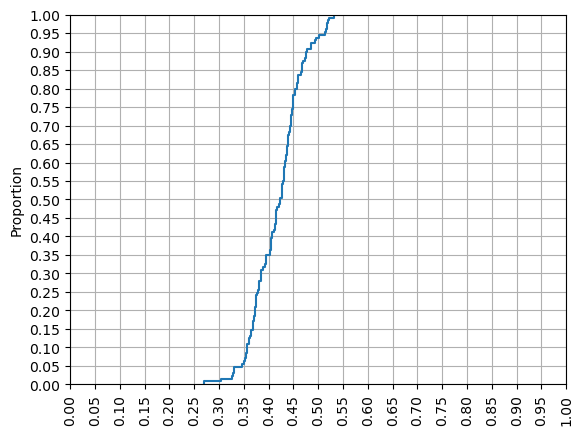

In [ ]:
sns.ecdfplot(tolerance)
plt.xticks([i/20 for i in range(21)], rotation=90)
plt.yticks([i/20 for i in range(21)])
plt.grid()
plt.show()

In [ ]:
tolerance = []
for person_1_img in tqdm(os.listdir(DB_SOURCE)):
    person_1_name = ".".join(person_1_img.split(".")[:-1])
    person_1_path = str(DB_SOURCE / person_1_img)
    # print(person_1_path)
    person_1_image_arr = face_recognition.load_image_file(person_1_path)
    person_1_image_enc = face_encodings(person_1_image_arr)
    known_faces = []
    for person_2_img in os.listdir(QUERY_SOURCE / person_1_name):
        person_2_path = str(QUERY_SOURCE / person_1_name / person_2_img)
        person_2_image_arr = face_recognition.load_image_file(person_2_path)
        person_2_image_enc = face_encodings(person_2_image_arr)
        known_faces.append(person_2_image_enc)
        # print(person_2_path)
    tances = face_recognition.face_tance(
        face_encodings = known_faces, 
        face_to_compare = person_1_image_enc
    )
    # print(tances)
    # tolerance.append(np.median(tances))
    tolerance.extend(tances)
    # print()
tolerance

100%|█████████████████████████████████████████| 129/129 [04:39<00:00,  2.16s/it]


[0.32529662366799594,
 0.3518861090715766,
 0.4622422844508665,
 0.37848727034679025,
 0.3556061539451734,
 0.49994207652931233,
 0.3436450327460892,
 0.44610729052922704,
 0.4029228235224444,
 0.43882977533940576,
 0.4968868439074121,
 0.4577856250826683,
 0.4175133885751445,
 0.4085868478308186,
 0.4832664590987744,
 0.5162375678348011,
 0.3624124894223383,
 0.5461895275499051,
 0.4410778244385062,
 0.5271501586385389,
 0.10951328918756621,
 0.4333255884769855,
 0.33719212589482755,
 0.34650711539556717,
 0.4305493821522119,
 0.40722238413756184,
 0.228131662204417,
 0.4016819332194532,
 0.38785765258669247,
 0.49896665708588483,
 0.43397525551181904,
 0.36440630517314204,
 0.31814235634109295,
 0.44864658944511443,
 0.3628007587339854,
 0.3849823077217564,
 0.451424522476863,
 0.36450749523915243,
 0.4958027396611777,
 0.414546116829475,
 0.4281635857370875,
 0.2917510750894158,
 0.305461010553306,
 0.3563400127245326,
 0.4165875524121304,
 0.40224171030042954,
 0.5537863033898185,


In [ ]:
np.percentile(tolerance, 99)

0.6094068052287842

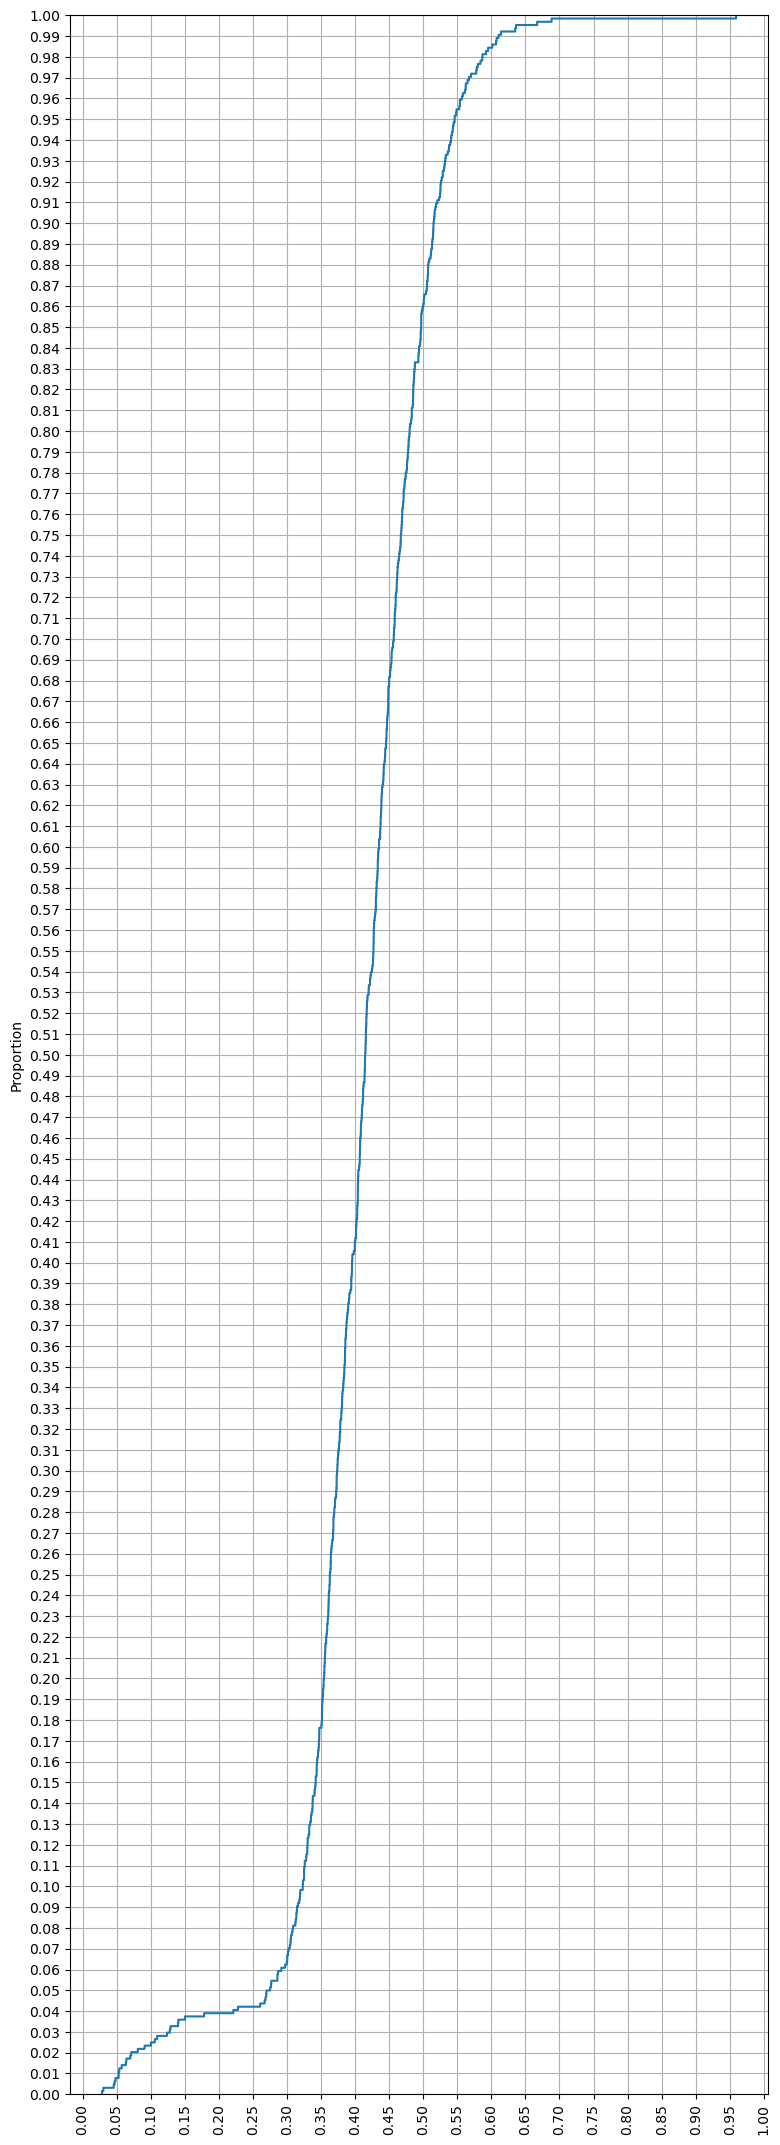

In [ ]:
plt.figure(figsize=(9, 27))
sns.ecdfplot(tolerance)
plt.xticks([i/20 for i in range(21)], rotation=90)
plt.yticks([i/100 for i in range(101)])
plt.grid()
plt.show()

### Extracting Face Bounding Box with Deep learning

In [59]:
face_recognition.face_locations(
    img = face_recognition.load_image_file("QueryImages/Divyendu Sharma/5.png"),
    number_of_times_to_upsample = 1,
    model = "cnn"
)

[(180, 335, 603, 0)]

In [60]:
positive_img_arr = face_recognition.load_image_file(
    "QueryImages/Divyendu Sharma/5.png"
)

positive_image_enc = face_recognition.face_encodings(
    face_image = positive_img_arr,
    known_face_locations = face_recognition.face_locations(
        img = positive_img_arr,
        number_of_times_to_upsample = 1,
        model = "cnn"
    ),
    num_jitters = 1,
    model = 'large',
)[0]

positive_image_enc

array([-0.11800198,  0.09467008,  0.08731739, -0.08859541, -0.03324034,
       -0.0327717 , -0.11298256, -0.1143096 ,  0.10522072, -0.18608832,
        0.29453772, -0.05663745, -0.23187064, -0.06183244,  0.00401195,
        0.0533325 , -0.12491174, -0.08371996, -0.07305332, -0.14576431,
        0.03851146,  0.14842357, -0.01146456,  0.07049698, -0.13293102,
       -0.37068564, -0.10376748, -0.09127804,  0.06147016, -0.09748858,
       -0.00691863,  0.00983575, -0.13787499, -0.03382872,  0.02826873,
        0.11273205,  0.00350514, -0.07404049,  0.2031565 ,  0.0457464 ,
       -0.0965406 , -0.03732779,  0.06497445,  0.25695261,  0.14201789,
        0.02316722,  0.06257673, -0.03688949,  0.1620328 , -0.18482399,
        0.05018687,  0.12242846,  0.14377327,  0.0547768 ,  0.16889788,
       -0.17922083, -0.00807369,  0.1518631 , -0.16884108,  0.14058867,
        0.01736558, -0.04916614,  0.00391425,  0.0252006 ,  0.17710841,
        0.08060867, -0.08623738, -0.20788889,  0.18082452, -0.19

## Inferance

In [44]:
def path_dis_processing(neighbour_idxs, distances):
    neighbour_idx_dis_pairs = list(zip(neighbour_idxs, distances))
    neighbour_idx_dis_pairs_sorted_in_asc_ord = list(sorted(
        neighbour_idx_dis_pairs, 
        key=lambda idx_dis: idx_dis[1],
        reverse=False  
    )) 
    neighbour_img_path_dis_pairs_sorted_in_asc_ord = [
        [DB_FACE_PATHS[idx], dis] for [idx, dis] in neighbour_idx_dis_pairs_sorted_in_asc_ord
    ]
    return neighbour_img_path_dis_pairs_sorted_in_asc_ord[1:] 

In [53]:
def top_4_matching_faces(neighbour_img_path_dis_pairs_sorted_in_asc_ord):
    entry_flag_dic = dict()
    result = []
    for neigh_img_path, dis in neighbour_img_path_dis_pairs_sorted_in_asc_ord:
        if os.path.dirname(neigh_img_path).split("/")[-1] not in entry_flag_dic:
            entry_flag_dic[os.path.dirname(neigh_img_path).split("/")[-1]] = True
            result.append([neigh_img_path, dis])
    return result[:4] 

In [54]:
def gathering_the_surrounding_known_faces(neighbour_idxs):
    known_faces = []
    for neigh_idx in neighbour_idxs:
        neigh_img_path = DB_FACE_PATHS[neigh_idx]
        known_face_locations = DB_FACE_COORDINATES[neigh_idx]
        neigh_img_enc = face_enc_with_fr(
            neigh_img_path, 
            known_face_locations=known_face_locations
        )
        known_faces.append(neigh_img_enc)
    return known_faces

In [55]:
def predict(target_path, k=10):
    # embedding the face
    [tar_enc, tar_coordinates] = face_enc_and_coordinates_with_df(target_path) 
    tar_enc = np.expand_dims(tar_enc, axis=0)
    # extracting the closest k embedding indexes
    distances, neighbour_idxs = FAISS_INDEXING_OBJ.search(tar_enc, k)
    neighbour_idxs, distances = neighbour_idxs[0], distances[0]
    # gather the surrounding known faces
    known_faces = gathering_the_surrounding_known_faces(neighbour_idxs)
    # calculating the distance between the target face and the closest k faces
    tar_enc = face_enc_with_fr(
        target_path, 
        known_face_locations=tar_coordinates
    )
    distances = face_recognition.face_distance(
        face_encodings=known_faces, 
        face_to_compare=tar_enc
    )
    # processing the image path and distance from target in ascending order
    neighbour_img_path_dis_pairs_sorted_in_asc_ord = path_dis_processing(
        neighbour_idxs, 
        distances
    )
    return top_4_matching_faces(neighbour_img_path_dis_pairs_sorted_in_asc_ord) 

In [56]:
tic = time.time()

# result = predict("../data/CleanData/anupama_parameswaran/1.jpg") 
# result = predict("../data/CleanData/aamir_khan/5.jpg")
# result = predict("../data/CleanData/kartik_aaryan/5.jpg") 
# result = predict("../data/CleanData/anupama_parameswaran/5.jpg") 
result = predict("../data/CleanData/alizeh_shah/5.jpg") 
# result = predict("../data/CleanData/aamir_khan/5.jpg") 
# result = predict("../data/CleanData/priyanka_arul_mohan/5.jpg") 
# result = predict("../data/CleanData/saikrishna/5.jpeg") 
# result = predict("../data/CleanData/sadak/5.jpg") 
# result = predict("../data/CleanData/catherine_tresa/4.jpg") 

# result = predict("Unknown/0ca8af14c1.jpg") 

for item in result:
    print(item)
print()

toc = time.time()
print(f"search completed in {toc - tic} seconds")

1/1 [==============================] - 0s 20ms/step
['../data/CleanData/alizeh_shah/4.jpg', 0.4741337131828169]
['../data/CleanData/lavanya_tripathi/0.png', 0.5134807529727985]
['../data/CleanData/sayyeshaa_saigal/5.jpg', 0.5625392763675945]
["../data/CleanData/ileana_d'cruz/5.jpg", 0.5714622545368838]

search completed in 1.8932287693023682 seconds


## Accuracy

In [58]:
def matching(neigh_img_path, target_path):
    # print(neigh_img_path, person_name)
    # print(os.path.dirname(neigh_img_path).split("/")[-1], person_name)
    target_name = os.path.dirname(target_path).split("/")[-1]
    neigh_name = os.path.dirname(neigh_img_path).split("/")[-1]
    # print(target_name, neigh_name)
    return target_name == neigh_name 

In [59]:
TP = 0
FN = 0
position = []
FN_responses = []

for target_path in tqdm(DB_FACE_PATHS):
    result = predict(target_path)
    match_flag = False 
    for idx, [neigh_img_path, dis] in enumerate(result):
        if matching(neigh_img_path, target_path): 
            TP += 1
            match_flag = True
            position.append([idx, [target_path, result]]) 
            break 
    if match_flag == False:
        FN += 1
        FN_responses.append([target_path, result])
        print(target_path)
        print(result)
        print()

  0%|          | 0/768 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/768 [00:02<25:46,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/768 [00:03<23:02,  1.80s/it]

1/1 [==============================] - 0s 24ms/step


  0%|          | 3/768 [00:05<22:47,  1.79s/it]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/768 [00:07<22:13,  1.75s/it]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/768 [00:08<21:45,  1.71s/it]

1/1 [==============================] - 0s 20ms/step


  1%|          | 6/768 [00:10<21:46,  1.72s/it]

1/1 [==============================] - 0s 20ms/step


  1%|          | 7/768 [00:12<22:04,  1.74s/it]

1/1 [==============================] - 0s 23ms/step


  1%|          | 8/768 [00:14<22:05,  1.74s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 9/768 [00:16<22:56,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 10/768 [00:17<23:20,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 11/768 [00:19<23:10,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 12/768 [00:21<24:33,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 13/768 [00:23<24:18,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/768 [00:25<23:13,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/768 [00:27<22:14,  1.77s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 16/768 [00:28<22:10,  1.77s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 17/768 [00:30<22:07,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 18/768 [00:32<21:38,  1.73s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 19/768 [00:34<21:48,  1.75s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/768 [00:35<21:35,  1.73s/it]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 21/768 [00:37<21:03,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 22/768 [00:39<21:16,  1.71s/it]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 23/768 [00:40<21:21,  1.72s/it]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 24/768 [00:42<21:14,  1.71s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 25/768 [00:44<21:28,  1.73s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 26/768 [00:46<21:17,  1.72s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 27/768 [00:47<21:51,  1.77s/it]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 28/768 [00:50<24:53,  2.02s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 29/768 [00:52<23:57,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 30/768 [00:54<24:33,  2.00s/it]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 31/768 [00:56<26:07,  2.13s/it]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 32/768 [00:59<26:45,  2.18s/it]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 33/768 [01:01<25:50,  2.11s/it]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 34/768 [01:02<24:21,  1.99s/it]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 35/768 [01:04<23:40,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 36/768 [01:06<23:17,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 37/768 [01:08<23:23,  1.92s/it]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 38/768 [01:10<22:46,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 39/768 [01:11<21:28,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 40/768 [01:13<21:10,  1.75s/it]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 41/768 [01:14<20:44,  1.71s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 42/768 [01:16<20:34,  1.70s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 43/768 [01:18<20:20,  1.68s/it]

../data/CleanData/anaika_soti/2.png
[['../data/CleanData/charmy_kaur/1.jpg', 0.5023568856408094], ['../data/CleanData/bhoomika_chawla/0.jpg', 0.5716371679548409], ['../data/CleanData/alizeh_shah/0.png', 0.5890573988329176], ['../data/CleanData/catherine_tresa/1.jpg', 0.6076476496117454]]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 44/768 [01:20<22:54,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 45/768 [01:22<22:34,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 46/768 [01:24<22:05,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 47/768 [01:26<21:54,  1.82s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 48/768 [01:27<21:27,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 49/768 [01:30<23:02,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 50/768 [01:31<22:22,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 51/768 [01:33<21:43,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 52/768 [01:35<21:37,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 53/768 [01:37<21:22,  1.79s/it]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 54/768 [01:38<20:54,  1.76s/it]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 55/768 [01:40<22:00,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 56/768 [01:42<21:55,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 57/768 [01:44<22:36,  1.91s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 58/768 [01:46<23:20,  1.97s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 59/768 [01:49<24:21,  2.06s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 60/768 [01:50<23:12,  1.97s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 61/768 [01:52<23:00,  1.95s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 62/768 [01:54<22:47,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 63/768 [01:56<22:29,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 64/768 [01:58<22:06,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 65/768 [02:00<22:06,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 66/768 [02:02<22:31,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 67/768 [02:04<23:41,  2.03s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 68/768 [02:06<23:43,  2.03s/it]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 69/768 [02:08<23:21,  2.00s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 70/768 [02:10<22:36,  1.94s/it]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 71/768 [02:12<22:09,  1.91s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 72/768 [02:13<22:14,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 73/768 [02:16<22:58,  1.98s/it]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 74/768 [02:17<21:51,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 75/768 [02:19<21:30,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 76/768 [02:21<21:06,  1.83s/it]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 77/768 [02:23<21:03,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 78/768 [02:24<20:28,  1.78s/it]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 79/768 [02:26<21:43,  1.89s/it]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 80/768 [02:28<22:00,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 81/768 [02:30<21:48,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 82/768 [02:32<21:18,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 83/768 [02:34<20:48,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 84/768 [02:36<20:27,  1.79s/it]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 85/768 [02:38<21:50,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 86/768 [02:40<21:11,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 87/768 [02:41<20:37,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 88/768 [02:43<21:33,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 89/768 [02:45<20:38,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 90/768 [02:47<20:20,  1.80s/it]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 91/768 [02:49<21:13,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 92/768 [02:51<21:10,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 93/768 [02:52<20:14,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 94/768 [02:54<20:13,  1.80s/it]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 95/768 [02:56<20:21,  1.82s/it]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 96/768 [02:59<24:21,  2.17s/it]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 97/768 [03:01<22:57,  2.05s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 98/768 [03:03<22:24,  2.01s/it]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 99/768 [03:05<23:12,  2.08s/it]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 100/768 [03:07<22:24,  2.01s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 101/768 [03:09<22:57,  2.06s/it]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 102/768 [03:11<21:41,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 103/768 [03:12<20:59,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 104/768 [03:14<20:17,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 105/768 [03:16<19:59,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 106/768 [03:17<19:18,  1.75s/it]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 107/768 [03:19<19:24,  1.76s/it]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 108/768 [03:21<19:25,  1.77s/it]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 109/768 [03:23<19:26,  1.77s/it]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 110/768 [03:25<19:56,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 111/768 [03:26<19:43,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 112/768 [03:28<20:24,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 113/768 [03:30<20:13,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 114/768 [03:32<20:45,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 115/768 [03:34<21:18,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 116/768 [03:36<20:11,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 117/768 [03:38<20:05,  1.85s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 118/768 [03:40<19:51,  1.83s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 119/768 [03:42<20:33,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 120/768 [03:43<20:11,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 121/768 [03:45<20:22,  1.89s/it]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 122/768 [03:47<19:51,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 123/768 [03:49<19:28,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 124/768 [03:51<18:50,  1.76s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 125/768 [03:52<19:07,  1.78s/it]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 126/768 [03:54<19:05,  1.78s/it]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 127/768 [03:56<20:03,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 128/768 [03:58<19:40,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 129/768 [04:00<19:33,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 130/768 [04:02<19:43,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 131/768 [04:04<19:55,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 132/768 [04:05<19:29,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 133/768 [04:07<18:59,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 134/768 [04:09<20:26,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 135/768 [04:11<19:19,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 136/768 [04:13<19:05,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 137/768 [04:14<18:22,  1.75s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 138/768 [04:16<18:07,  1.73s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 139/768 [04:19<20:37,  1.97s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 140/768 [04:20<20:13,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 141/768 [04:22<19:45,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 142/768 [04:24<19:28,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 143/768 [04:26<19:09,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 144/768 [04:28<19:07,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 145/768 [04:29<19:01,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 146/768 [04:31<19:43,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 147/768 [04:33<19:00,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 148/768 [04:35<18:12,  1.76s/it]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 149/768 [04:37<19:31,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 150/768 [04:39<19:59,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 151/768 [04:41<20:10,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 152/768 [04:43<19:21,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 153/768 [04:45<19:04,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 154/768 [04:46<18:35,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 155/768 [04:48<18:48,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 156/768 [04:50<18:37,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 157/768 [04:52<18:27,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 158/768 [04:54<18:56,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 159/768 [04:55<18:40,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 160/768 [04:57<18:42,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 161/768 [04:59<18:27,  1.82s/it]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 162/768 [05:01<19:55,  1.97s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 163/768 [05:04<20:44,  2.06s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 164/768 [05:06<21:27,  2.13s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 165/768 [05:08<22:29,  2.24s/it]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 166/768 [05:11<22:17,  2.22s/it]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 167/768 [05:13<22:29,  2.25s/it]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 168/768 [05:15<22:47,  2.28s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 169/768 [05:17<21:44,  2.18s/it]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 170/768 [05:19<20:34,  2.06s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 171/768 [05:21<19:42,  1.98s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 172/768 [05:23<19:36,  1.97s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 173/768 [05:25<20:05,  2.03s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 174/768 [05:27<19:35,  1.98s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 175/768 [05:29<20:22,  2.06s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 176/768 [05:31<19:54,  2.02s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 177/768 [05:33<19:44,  2.00s/it]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 178/768 [05:35<19:41,  2.00s/it]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 179/768 [05:37<18:54,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 180/768 [05:38<18:23,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 181/768 [05:40<18:46,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 182/768 [05:42<18:06,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 183/768 [05:44<19:16,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 184/768 [05:46<18:19,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 185/768 [05:48<18:00,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 186/768 [05:50<18:25,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 187/768 [05:52<18:08,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 188/768 [05:54<17:53,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 189/768 [05:55<17:13,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 190/768 [05:57<17:24,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 191/768 [05:59<17:19,  1.80s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 192/768 [06:01<17:03,  1.78s/it]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 193/768 [06:02<17:21,  1.81s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 194/768 [06:05<18:35,  1.94s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 195/768 [06:07<18:59,  1.99s/it]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 196/768 [06:09<18:37,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 197/768 [06:10<18:10,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 198/768 [06:12<17:57,  1.89s/it]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 199/768 [06:15<19:45,  2.08s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 200/768 [06:17<19:36,  2.07s/it]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 201/768 [06:19<19:38,  2.08s/it]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 202/768 [06:21<20:11,  2.14s/it]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 203/768 [06:24<22:12,  2.36s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 204/768 [06:27<22:21,  2.38s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 205/768 [06:29<21:17,  2.27s/it]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 206/768 [06:30<19:26,  2.07s/it]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 207/768 [06:32<18:50,  2.02s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 208/768 [06:34<18:43,  2.01s/it]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 209/768 [06:36<18:51,  2.02s/it]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 210/768 [06:38<17:51,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 211/768 [06:40<18:08,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 212/768 [06:42<18:01,  1.94s/it]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 213/768 [06:43<17:29,  1.89s/it]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 214/768 [06:45<16:46,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 215/768 [06:47<16:18,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 216/768 [06:49<16:27,  1.79s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 217/768 [06:51<17:43,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 218/768 [06:53<16:52,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 219/768 [06:54<17:08,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 220/768 [06:56<17:11,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 221/768 [06:58<16:48,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 222/768 [07:00<16:47,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 223/768 [07:02<17:29,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 224/768 [07:04<17:59,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 225/768 [07:06<17:27,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 226/768 [07:08<17:04,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 227/768 [07:09<16:28,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 228/768 [07:11<16:43,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 229/768 [07:13<16:44,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 230/768 [07:15<17:02,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 231/768 [07:17<16:39,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 232/768 [07:19<16:23,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 233/768 [07:21<16:59,  1.91s/it]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 234/768 [07:23<16:57,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 235/768 [07:25<17:32,  1.97s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 236/768 [07:27<17:24,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 237/768 [07:29<17:35,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 238/768 [07:31<16:46,  1.90s/it]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 239/768 [07:33<16:56,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 240/768 [07:34<16:29,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 241/768 [07:37<17:43,  2.02s/it]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 242/768 [07:39<17:15,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 243/768 [07:40<17:03,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 244/768 [07:42<16:47,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 245/768 [07:45<17:34,  2.02s/it]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 246/768 [07:46<17:01,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 247/768 [07:48<16:37,  1.91s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 248/768 [07:50<17:07,  1.98s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 249/768 [07:52<16:22,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 250/768 [07:54<15:37,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 251/768 [07:55<15:13,  1.77s/it]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 252/768 [07:57<16:09,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 253/768 [07:59<15:34,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 254/768 [08:01<15:18,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 255/768 [08:03<16:03,  1.88s/it]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 256/768 [08:05<16:24,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 257/768 [08:07<16:01,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 258/768 [08:09<15:51,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 259/768 [08:10<15:45,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 260/768 [08:12<15:39,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 261/768 [08:14<15:03,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 262/768 [08:16<15:46,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 263/768 [08:18<15:19,  1.82s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 264/768 [08:20<15:37,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 265/768 [08:22<16:29,  1.97s/it]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 266/768 [08:23<15:27,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 267/768 [08:25<14:59,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 268/768 [08:27<14:59,  1.80s/it]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 269/768 [08:29<15:00,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 270/768 [08:31<15:09,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 271/768 [08:32<15:16,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 272/768 [08:34<14:52,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 273/768 [08:36<14:24,  1.75s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 274/768 [08:38<15:40,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 275/768 [08:40<15:04,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 276/768 [08:42<15:08,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 277/768 [08:45<19:59,  2.44s/it]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 278/768 [08:47<18:41,  2.29s/it]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 279/768 [08:49<17:01,  2.09s/it]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 280/768 [08:51<16:25,  2.02s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 281/768 [08:53<16:01,  1.97s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 282/768 [08:54<15:21,  1.90s/it]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 283/768 [08:56<15:47,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 284/768 [08:58<14:58,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 285/768 [09:00<14:40,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 286/768 [09:02<14:32,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 287/768 [09:03<14:29,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 288/768 [09:05<14:04,  1.76s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 289/768 [09:07<13:57,  1.75s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 290/768 [09:09<14:11,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 291/768 [09:10<13:45,  1.73s/it]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 292/768 [09:12<14:42,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 293/768 [09:14<15:08,  1.91s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 294/768 [09:16<14:49,  1.88s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 295/768 [09:18<14:42,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 296/768 [09:20<14:32,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 297/768 [09:22<14:24,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 298/768 [09:24<15:18,  1.95s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 299/768 [09:26<15:31,  1.99s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 300/768 [09:28<15:26,  1.98s/it]

2/2 [==============================] - 0s 7ms/step


 39%|███▉      | 301/768 [09:31<16:57,  2.18s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 302/768 [09:32<15:39,  2.02s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 303/768 [09:34<15:19,  1.98s/it]

3/3 [==============================] - 0s 9ms/step


 40%|███▉      | 304/768 [09:37<16:45,  2.17s/it]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 305/768 [09:39<15:59,  2.07s/it]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 306/768 [09:41<15:38,  2.03s/it]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 307/768 [09:43<15:33,  2.02s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 308/768 [09:45<15:57,  2.08s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 309/768 [09:46<15:06,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 310/768 [09:48<14:46,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 311/768 [09:50<14:16,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 312/768 [09:52<13:51,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 313/768 [09:54<14:18,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 314/768 [09:56<14:04,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 315/768 [09:57<13:38,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 316/768 [09:59<13:45,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 317/768 [10:01<13:32,  1.80s/it]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 318/768 [10:03<13:10,  1.76s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 319/768 [10:05<13:54,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 320/768 [10:06<13:51,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 321/768 [10:08<13:24,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 322/768 [10:10<13:11,  1.78s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 323/768 [10:12<13:11,  1.78s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 324/768 [10:13<13:12,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 325/768 [10:16<15:02,  2.04s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 326/768 [10:18<14:51,  2.02s/it]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 327/768 [10:20<14:31,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 328/768 [10:22<14:09,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 329/768 [10:24<14:12,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 330/768 [10:26<14:48,  2.03s/it]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 331/768 [10:28<14:04,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 332/768 [10:30<14:30,  2.00s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 333/768 [10:32<13:48,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 334/768 [10:33<13:28,  1.86s/it]

../data/CleanData/prabhas/4.jpg
[['../data/CleanData/ajmal_ameer/0.jpg', 0.5595533139767448], ['../data/CleanData/arjun_kapoor/2.png', 0.5648563808054842], ['../data/CleanData/naveen_polishetty/2.jpg', 0.5880388929897409], ['../data/CleanData/n_t_rama_rao_jr/2.jpg', 0.6037597105357764]]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 335/768 [10:35<13:09,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 336/768 [10:37<12:38,  1.75s/it]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 337/768 [10:38<12:42,  1.77s/it]

../data/CleanData/fahadh_faasil/2.png
[['../data/CleanData/nithin/4.jpg', 0.6597310252068185], ['../data/CleanData/aditya_roy_kapur/4.jpg', 0.7043054656731697], ['../data/CleanData/nidhhi_agerwal/3.jpg', 0.719715894359609], ['../data/CleanData/sai/2.jpeg', 0.7355175478041346]]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 338/768 [10:40<13:17,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 339/768 [10:42<12:59,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 340/768 [10:44<13:16,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 341/768 [10:46<12:52,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 342/768 [10:48<13:09,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 343/768 [10:50<13:31,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 344/768 [10:52<13:37,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 345/768 [10:54<13:28,  1.91s/it]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 346/768 [10:56<13:40,  1.94s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 347/768 [10:58<14:08,  2.01s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 348/768 [11:00<14:14,  2.04s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 349/768 [11:02<14:24,  2.06s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 350/768 [11:04<13:58,  2.01s/it]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 351/768 [11:06<13:45,  1.98s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 352/768 [11:07<12:55,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 353/768 [11:09<12:52,  1.86s/it]

../data/CleanData/alia_bhatt/4.jpg
[['../data/CleanData/nidhhi_agerwal/4.jpg', 0.6551642759135551], ['../data/CleanData/aditi_rao_hydari/2.png', 0.6765143316126354], ['../data/CleanData/shaheena/1.jpeg', 0.6791635315139474], ['../data/CleanData/kriti_kharbanda/3.jpg', 0.6889927568810402]]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 354/768 [11:11<12:37,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 355/768 [11:13<12:28,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 356/768 [11:15<12:30,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 357/768 [11:16<12:25,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 358/768 [11:18<12:40,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 359/768 [11:20<12:20,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 360/768 [11:22<12:21,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 361/768 [11:24<12:26,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 362/768 [11:26<12:03,  1.78s/it]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 363/768 [11:27<12:10,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 364/768 [11:29<11:59,  1.78s/it]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 365/768 [11:31<12:27,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 366/768 [11:33<12:21,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 367/768 [11:35<12:56,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 368/768 [11:37<12:47,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 369/768 [11:39<12:37,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 370/768 [11:41<12:33,  1.89s/it]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 371/768 [11:42<12:17,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 372/768 [11:44<12:11,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 373/768 [11:46<12:49,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 374/768 [11:48<12:39,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 375/768 [11:50<12:42,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 376/768 [11:52<12:25,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 377/768 [11:54<12:10,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 378/768 [11:56<12:09,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 379/768 [11:58<12:11,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 380/768 [11:59<11:50,  1.83s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 381/768 [12:01<11:52,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 382/768 [12:03<11:44,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 383/768 [12:05<11:32,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 384/768 [12:07<11:48,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 385/768 [12:09<12:05,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 386/768 [12:11<11:48,  1.86s/it]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 387/768 [12:12<11:33,  1.82s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 388/768 [12:14<11:23,  1.80s/it]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 389/768 [12:16<11:20,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 390/768 [12:18<12:00,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 391/768 [12:20<11:41,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 392/768 [12:22<11:52,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 393/768 [12:23<11:25,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 394/768 [12:25<10:49,  1.74s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 395/768 [12:27<10:50,  1.74s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 396/768 [12:28<10:51,  1.75s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 397/768 [12:31<11:52,  1.92s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 398/768 [12:33<13:01,  2.11s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 399/768 [12:35<12:54,  2.10s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 400/768 [12:38<12:54,  2.10s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 401/768 [12:40<13:00,  2.13s/it]

3/3 [==============================] - 0s 8ms/step


 52%|█████▏    | 402/768 [12:42<13:59,  2.29s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 403/768 [12:44<13:25,  2.21s/it]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 404/768 [12:46<12:20,  2.04s/it]

../data/CleanData/asin_thottumkal/0.png
[['../data/CleanData/nivetha_thomas/2.jpg', 0.49368245152972096], ['../data/CleanData/amala_paul/2.jpg', 0.49690808410558335], ['../data/CleanData/nabha_natesh/2.jpg', 0.5619887523200883], ['../data/CleanData/mouni_roy/2.jpeg', 0.5633261809000041]]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 405/768 [12:48<12:12,  2.02s/it]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 406/768 [12:50<11:46,  1.95s/it]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 407/768 [12:52<12:11,  2.03s/it]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 408/768 [12:54<11:50,  1.97s/it]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 409/768 [12:56<11:54,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 410/768 [12:58<11:34,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 411/768 [13:00<11:24,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 412/768 [13:02<11:28,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 413/768 [13:03<11:29,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 414/768 [13:05<10:56,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 415/768 [13:07<11:07,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 416/768 [13:09<10:51,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 417/768 [13:11<10:32,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 418/768 [13:12<10:17,  1.76s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 419/768 [13:14<10:34,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 420/768 [13:16<10:43,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 421/768 [13:18<11:02,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 422/768 [13:20<10:50,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 423/768 [13:22<10:56,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 424/768 [13:24<10:40,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 425/768 [13:26<10:42,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 426/768 [13:27<10:24,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 427/768 [13:29<10:36,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 428/768 [13:31<10:32,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 429/768 [13:33<10:12,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 430/768 [13:35<10:22,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 431/768 [13:36<09:55,  1.77s/it]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 432/768 [13:38<09:33,  1.71s/it]

../data/CleanData/kiara_advani/1.jpg
[['../data/CleanData/nivetha_thomas/3.jpeg', 0.5351058765779734], ['../data/CleanData/alizeh_shah/0.png', 0.5626749624073983], ['../data/CleanData/charmy_kaur/1.jpg', 0.57625683598872], ['../data/CleanData/parineeti_chopra/1.jpg', 0.5855657179543803]]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 433/768 [13:40<09:56,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 434/768 [13:42<09:46,  1.75s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 435/768 [13:43<10:06,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 436/768 [13:46<10:25,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 437/768 [13:47<10:18,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 438/768 [13:49<10:14,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 439/768 [13:51<10:30,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 440/768 [13:53<10:07,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 441/768 [13:55<10:05,  1.85s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 442/768 [13:57<09:55,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 443/768 [13:59<10:17,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 444/768 [14:00<10:02,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 445/768 [14:02<09:55,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 446/768 [14:04<09:53,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 447/768 [14:06<09:38,  1.80s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 448/768 [14:08<09:40,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 449/768 [14:09<09:17,  1.75s/it]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 450/768 [14:11<09:11,  1.74s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 451/768 [14:13<09:35,  1.82s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 452/768 [14:15<09:25,  1.79s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 453/768 [14:16<09:12,  1.75s/it]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 454/768 [14:18<09:10,  1.75s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 455/768 [14:20<09:40,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 456/768 [14:22<09:47,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 457/768 [14:24<09:59,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 458/768 [14:26<09:45,  1.89s/it]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 459/768 [14:28<10:41,  2.08s/it]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 460/768 [14:30<10:04,  1.96s/it]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 461/768 [14:32<09:45,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 462/768 [14:34<09:32,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 463/768 [14:35<09:20,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 464/768 [14:37<09:09,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 465/768 [14:39<09:32,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 466/768 [14:41<09:29,  1.88s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 467/768 [14:43<09:28,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 468/768 [14:45<09:15,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 469/768 [14:47<09:18,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 470/768 [14:49<09:25,  1.90s/it]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 471/768 [14:51<09:16,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 472/768 [14:52<09:14,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 473/768 [14:54<09:06,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 474/768 [14:56<09:05,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 475/768 [14:58<09:46,  2.00s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 476/768 [15:00<09:20,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 477/768 [15:02<09:15,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 478/768 [15:04<08:51,  1.83s/it]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 479/768 [15:05<08:40,  1.80s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 480/768 [15:07<09:01,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 481/768 [15:09<09:12,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 482/768 [15:11<09:12,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 483/768 [15:13<08:51,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 484/768 [15:15<08:42,  1.84s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 485/768 [15:17<08:33,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 486/768 [15:19<08:49,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 487/768 [15:21<09:00,  1.92s/it]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 488/768 [15:22<08:42,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 489/768 [15:24<08:33,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 490/768 [15:26<08:43,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 491/768 [15:28<08:23,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 492/768 [15:30<08:17,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 493/768 [15:32<08:28,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 494/768 [15:33<08:16,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 495/768 [15:35<08:20,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 496/768 [15:37<08:09,  1.80s/it]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 497/768 [15:39<08:02,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 498/768 [15:41<08:08,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 499/768 [15:42<07:59,  1.78s/it]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 500/768 [15:44<08:00,  1.79s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 501/768 [15:46<07:45,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 502/768 [15:48<08:03,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 503/768 [15:49<07:51,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 504/768 [15:51<07:40,  1.74s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 505/768 [15:53<07:49,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 506/768 [15:54<07:30,  1.72s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 507/768 [15:56<07:26,  1.71s/it]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 508/768 [15:58<07:20,  1.69s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 509/768 [15:59<07:10,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 510/768 [16:01<07:03,  1.64s/it]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 511/768 [16:03<07:24,  1.73s/it]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 512/768 [16:05<07:21,  1.72s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 513/768 [16:06<07:06,  1.67s/it]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 514/768 [16:09<07:53,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 515/768 [16:10<07:45,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 516/768 [16:12<07:37,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 517/768 [16:14<07:37,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 518/768 [16:16<07:28,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 519/768 [16:18<07:59,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 520/768 [16:20<07:50,  1.90s/it]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 521/768 [16:22<07:43,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 522/768 [16:23<07:40,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 523/768 [16:25<07:48,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 524/768 [16:27<07:31,  1.85s/it]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 525/768 [16:29<07:16,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 526/768 [16:31<07:27,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 527/768 [16:33<07:21,  1.83s/it]

../data/CleanData/mehreen_pirzada/3.png
[['../data/CleanData/eesha_rebba/5.jpg', 0.4243464093868265], ['../data/CleanData/barkha_singh/2.jpg', 0.5297383872954952], ['../data/CleanData/amala_paul/3.png', 0.5495259949591258], ['../data/CleanData/nidhhi_agerwal/1.jpg', 0.5663409879811374]]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 528/768 [16:34<07:16,  1.82s/it]

../data/CleanData/mehreen_pirzada/1.jpg
[['../data/CleanData/bhoomika_chawla/0.jpg', 0.5049385704668848], ['../data/CleanData/disha_patani/5.jpg', 0.5382688474420356], ['../data/CleanData/dia_mirza/3.jpg', 0.5395151696357288], ['../data/CleanData/anupama_parameswaran/4.jpg', 0.5673167646068499]]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 529/768 [16:37<07:52,  1.98s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 530/768 [16:39<07:48,  1.97s/it]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 531/768 [16:40<07:29,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 532/768 [16:42<07:30,  1.91s/it]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 533/768 [16:44<07:17,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 534/768 [16:46<07:09,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 535/768 [16:48<07:00,  1.81s/it]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 536/768 [16:50<07:53,  2.04s/it]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 537/768 [16:52<07:31,  1.95s/it]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 538/768 [16:54<07:32,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 539/768 [16:56<07:14,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 540/768 [16:57<07:06,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 541/768 [17:00<07:27,  1.97s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 542/768 [17:02<07:53,  2.10s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 543/768 [17:04<07:46,  2.07s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 544/768 [17:07<08:29,  2.28s/it]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 545/768 [17:09<08:34,  2.31s/it]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 546/768 [17:12<08:33,  2.31s/it]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 547/768 [17:13<08:05,  2.19s/it]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 548/768 [17:15<07:32,  2.05s/it]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 549/768 [17:17<07:00,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 550/768 [17:19<06:47,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 551/768 [17:20<06:31,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 552/768 [17:22<06:42,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 553/768 [17:24<06:27,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 554/768 [17:26<06:45,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 555/768 [17:28<06:37,  1.87s/it]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 556/768 [17:30<06:42,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 557/768 [17:31<06:30,  1.85s/it]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 558/768 [17:33<06:30,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 559/768 [17:35<06:28,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 560/768 [17:37<06:20,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 561/768 [17:39<06:09,  1.79s/it]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 562/768 [17:40<06:01,  1.75s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 563/768 [17:42<06:11,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 564/768 [17:44<05:59,  1.76s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 565/768 [17:46<06:04,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 566/768 [17:48<06:32,  1.94s/it]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 567/768 [17:50<06:15,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 568/768 [17:52<06:33,  1.97s/it]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 569/768 [17:54<06:13,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 570/768 [17:55<05:58,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 571/768 [17:57<06:08,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 572/768 [17:59<05:55,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 573/768 [18:01<05:48,  1.79s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 574/768 [18:02<05:44,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 575/768 [18:05<06:21,  1.98s/it]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 576/768 [18:07<06:11,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 577/768 [18:09<06:29,  2.04s/it]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 578/768 [18:11<06:30,  2.05s/it]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 579/768 [18:13<06:18,  2.00s/it]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 580/768 [18:15<06:02,  1.93s/it]

../data/CleanData/catherine_tresa/4.jpg
[['../data/CleanData/niharika_konidela/4.jpeg', 0.49957967456853314], ['../data/CleanData/nivetha_thomas/2.jpg', 0.5131764610851045], ['../data/CleanData/keerthi_suresh/4.jpg', 0.5140430864071595], ['../data/CleanData/kiara_advani/0.jpg', 0.5257267210335673]]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 581/768 [18:16<05:43,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 582/768 [18:18<05:53,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 583/768 [18:20<05:53,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 584/768 [18:22<05:42,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 585/768 [18:24<05:46,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 586/768 [18:26<05:38,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 587/768 [18:28<05:36,  1.86s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 588/768 [18:30<05:43,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 589/768 [18:32<05:53,  1.98s/it]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 590/768 [18:34<05:47,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 591/768 [18:36<05:43,  1.94s/it]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 592/768 [18:38<05:40,  1.93s/it]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 593/768 [18:39<05:21,  1.84s/it]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 594/768 [18:41<05:25,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 595/768 [18:43<05:29,  1.91s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 596/768 [18:45<05:15,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 597/768 [18:47<05:14,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 598/768 [18:48<05:06,  1.81s/it]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 599/768 [18:50<05:11,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 600/768 [18:52<05:02,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 601/768 [18:54<05:06,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 602/768 [18:56<05:05,  1.84s/it]

../data/CleanData/lavanya_tripathi/0.png
[['../data/CleanData/disha_patani/1.jpg', 0.5024461186003067], ['../data/CleanData/alizeh_shah/5.jpg', 0.5134807529727985], ['../data/CleanData/fatima_sana_shaikh/3.jpg', 0.526712224925092], ['../data/CleanData/nabha_natesh/0.jpg', 0.5415112032519799]]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 603/768 [18:57<04:55,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 604/768 [18:59<04:51,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 605/768 [19:01<04:52,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 606/768 [19:03<04:54,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 607/768 [19:05<04:45,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 608/768 [19:07<04:53,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 609/768 [19:08<04:46,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 610/768 [19:10<04:47,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 611/768 [19:12<04:47,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 612/768 [19:14<04:44,  1.82s/it]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 613/768 [19:16<04:57,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 614/768 [19:18<04:45,  1.86s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 615/768 [19:19<04:43,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 616/768 [19:21<04:34,  1.80s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 617/768 [19:23<04:30,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 618/768 [19:25<04:28,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 619/768 [19:27<04:29,  1.81s/it]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 620/768 [19:29<04:40,  1.90s/it]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 621/768 [19:30<04:32,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 622/768 [19:32<04:28,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 623/768 [19:34<04:30,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 624/768 [19:36<04:28,  1.87s/it]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 625/768 [19:38<04:38,  1.95s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 626/768 [19:40<04:34,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 627/768 [19:42<04:32,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 628/768 [19:44<04:23,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 629/768 [19:45<04:10,  1.81s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 630/768 [19:47<04:18,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 631/768 [19:49<04:23,  1.92s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 632/768 [19:51<04:18,  1.90s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 633/768 [19:54<04:33,  2.03s/it]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 634/768 [19:55<04:17,  1.92s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 635/768 [19:57<04:13,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 636/768 [19:59<04:05,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 637/768 [20:01<04:04,  1.87s/it]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 638/768 [20:03<04:06,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 639/768 [20:05<04:01,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 640/768 [20:06<03:58,  1.86s/it]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 641/768 [20:08<04:01,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 642/768 [20:10<04:03,  1.93s/it]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 643/768 [20:12<04:05,  1.96s/it]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 644/768 [20:14<03:50,  1.86s/it]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 645/768 [20:16<03:56,  1.93s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 646/768 [20:18<04:09,  2.04s/it]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 647/768 [20:20<04:00,  1.99s/it]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 648/768 [20:22<03:52,  1.94s/it]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 649/768 [20:24<03:47,  1.91s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 650/768 [20:26<03:46,  1.92s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 651/768 [20:28<03:39,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 652/768 [20:30<03:39,  1.89s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 653/768 [20:32<03:46,  1.97s/it]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 654/768 [20:33<03:34,  1.88s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 655/768 [20:36<03:51,  2.05s/it]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 656/768 [20:38<03:35,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 657/768 [20:39<03:23,  1.83s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 658/768 [20:41<03:18,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 659/768 [20:43<03:13,  1.78s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 660/768 [20:45<03:16,  1.82s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 661/768 [20:47<03:21,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 662/768 [20:48<03:16,  1.85s/it]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 663/768 [20:50<03:10,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 664/768 [20:52<03:01,  1.74s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 665/768 [20:53<02:58,  1.73s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 666/768 [20:55<02:54,  1.71s/it]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 667/768 [20:57<03:00,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 668/768 [20:59<02:56,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 669/768 [21:01<02:59,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 670/768 [21:02<02:54,  1.79s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 671/768 [21:04<02:48,  1.74s/it]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 672/768 [21:06<02:44,  1.71s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 673/768 [21:07<02:45,  1.74s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 674/768 [21:09<02:38,  1.69s/it]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 675/768 [21:11<02:45,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 676/768 [21:13<02:50,  1.86s/it]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 677/768 [21:15<02:56,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 678/768 [21:17<02:49,  1.88s/it]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 679/768 [21:19<02:49,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 680/768 [21:21<02:44,  1.87s/it]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 681/768 [21:23<02:44,  1.89s/it]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 682/768 [21:24<02:41,  1.88s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 683/768 [21:26<02:38,  1.87s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 684/768 [21:28<02:33,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 685/768 [21:30<02:31,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 686/768 [21:32<02:28,  1.81s/it]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 687/768 [21:33<02:23,  1.77s/it]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 688/768 [21:35<02:18,  1.73s/it]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 689/768 [21:37<02:16,  1.73s/it]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 690/768 [21:39<02:22,  1.82s/it]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 691/768 [21:41<02:25,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 692/768 [21:43<02:34,  2.03s/it]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 693/768 [21:45<02:26,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 694/768 [21:47<02:19,  1.89s/it]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 695/768 [21:49<02:20,  1.92s/it]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 696/768 [21:50<02:15,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 697/768 [21:52<02:09,  1.82s/it]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 698/768 [21:54<02:11,  1.88s/it]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 699/768 [21:56<02:12,  1.92s/it]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 700/768 [21:59<02:28,  2.18s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 701/768 [22:01<02:20,  2.10s/it]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 702/768 [22:03<02:13,  2.02s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 703/768 [22:05<02:18,  2.13s/it]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 704/768 [22:07<02:07,  1.99s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 705/768 [22:09<02:03,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 706/768 [22:11<02:00,  1.95s/it]

../data/CleanData/naveen_polishetty/2.jpg
[['../data/CleanData/kalyan_ram/0.png', 0.4587061215692201], ['../data/CleanData/riteish_deshmukh/4.jpg', 0.5225965991015106], ['../data/CleanData/rajesh/1.jpg', 0.5479269307464397], ['../data/CleanData/n_t_rama_rao_jr/2.jpg', 0.5752216312756216]]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 707/768 [22:12<01:58,  1.94s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 708/768 [22:14<01:55,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 709/768 [22:16<01:50,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 710/768 [22:18<01:51,  1.93s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 711/768 [22:20<01:50,  1.93s/it]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 712/768 [22:22<01:46,  1.90s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 713/768 [22:24<01:41,  1.84s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 714/768 [22:25<01:39,  1.85s/it]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 715/768 [22:28<01:54,  2.16s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 716/768 [22:31<01:53,  2.19s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 717/768 [22:34<02:13,  2.62s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 718/768 [22:37<02:08,  2.57s/it]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 719/768 [22:40<02:12,  2.71s/it]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 720/768 [22:44<02:29,  3.10s/it]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 721/768 [22:46<02:11,  2.80s/it]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 722/768 [22:48<01:53,  2.46s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 723/768 [22:49<01:40,  2.23s/it]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 724/768 [22:51<01:37,  2.21s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 725/768 [22:53<01:28,  2.07s/it]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 726/768 [22:55<01:24,  2.00s/it]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 727/768 [22:57<01:26,  2.10s/it]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 728/768 [22:59<01:19,  2.00s/it]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 729/768 [23:01<01:14,  1.92s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 730/768 [23:02<01:10,  1.84s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 731/768 [23:04<01:05,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 732/768 [23:06<01:03,  1.76s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 733/768 [23:08<01:03,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 734/768 [23:10<01:01,  1.80s/it]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 735/768 [23:11<00:58,  1.76s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 736/768 [23:13<00:57,  1.79s/it]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 737/768 [23:15<00:55,  1.78s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 738/768 [23:17<00:53,  1.79s/it]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 739/768 [23:18<00:51,  1.78s/it]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 740/768 [23:20<00:48,  1.75s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 741/768 [23:22<00:47,  1.74s/it]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 742/768 [23:24<00:45,  1.75s/it]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 743/768 [23:25<00:42,  1.70s/it]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 744/768 [23:27<00:41,  1.73s/it]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 745/768 [23:29<00:39,  1.73s/it]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 746/768 [23:31<00:40,  1.84s/it]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 747/768 [23:33<00:37,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 748/768 [23:34<00:36,  1.83s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 749/768 [23:36<00:34,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 750/768 [23:38<00:32,  1.78s/it]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 751/768 [23:40<00:31,  1.83s/it]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 752/768 [23:42<00:31,  1.98s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 753/768 [23:44<00:28,  1.88s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 754/768 [23:46<00:26,  1.87s/it]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 755/768 [23:48<00:24,  1.89s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 756/768 [23:49<00:22,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 757/768 [23:52<00:22,  2.02s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 758/768 [23:58<00:33,  3.33s/it]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 759/768 [24:00<00:26,  2.97s/it]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 760/768 [24:03<00:22,  2.87s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 761/768 [24:05<00:19,  2.77s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 762/768 [24:08<00:16,  2.71s/it]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 763/768 [24:10<00:12,  2.58s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 764/768 [24:12<00:09,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 765/768 [24:14<00:06,  2.13s/it]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 766/768 [24:15<00:04,  2.01s/it]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 767/768 [24:17<00:01,  1.96s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 768/768 [24:19<00:00,  1.90s/it]


In [60]:
with open(f'../artifacts/position.pickle', 'wb') as handle:
    pickle.dump(position, handle, protocol = pickle.HIGHEST_PROTOCOL) 

with open(f'../artifacts/FN_responses.pickle', 'wb') as handle:
    pickle.dump(FN_responses, handle, protocol = pickle.HIGHEST_PROTOCOL) 

In [61]:
with open(f'../artifacts/position.pickle', 'rb') as handle:
    position = pickle.load(handle)

with open(f'../artifacts/FN_responses.pickle', 'rb') as handle:
    FN_responses = pickle.load(handle)

In [62]:
TP / (TP + FN) # TN, FP == 0 

0.9856770833333334

In [63]:
TP + FN

768

In [64]:
arr = np.array([item[0] for item in position])

In [65]:
for i in range(10): 
    print(np.sum(arr == i) / (TP + FN))

0.9557291666666666
0.020833333333333332
0.006510416666666667
0.0026041666666666665
0.0
0.0
0.0
0.0
0.0
0.0


In [66]:
(1 - 0.985677)*100

1.4322999999999975

../data/CleanData/anaika_soti/2.png


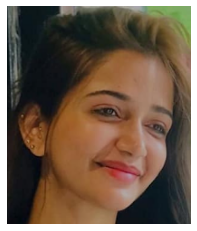

../data/CleanData/prabhas/4.jpg


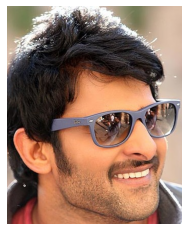

../data/CleanData/fahadh_faasil/2.png


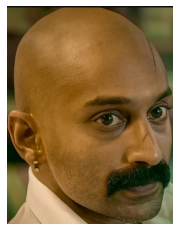

../data/CleanData/alia_bhatt/4.jpg


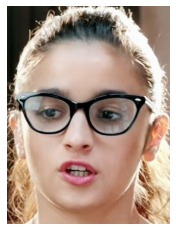

../data/CleanData/asin_thottumkal/0.png


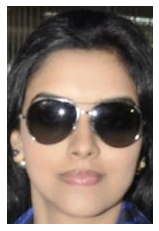

../data/CleanData/kiara_advani/1.jpg


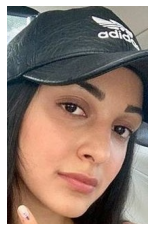

../data/CleanData/mehreen_pirzada/3.png


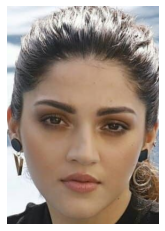

../data/CleanData/mehreen_pirzada/1.jpg


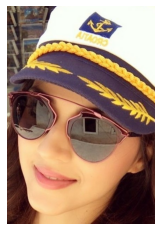

../data/CleanData/catherine_tresa/4.jpg


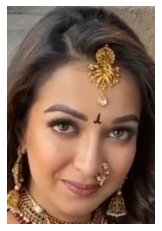

../data/CleanData/lavanya_tripathi/0.png


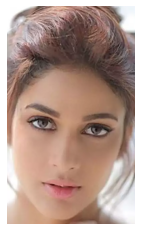

../data/CleanData/naveen_polishetty/2.jpg


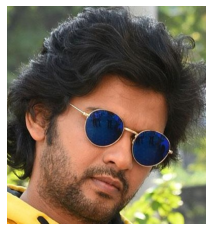

In [67]:
for item in FN_responses:
    img_path = item[0]
    print(img_path)
    show_pic(img_path)